# Pre-Photometry before measuring with GALFITM

In [1]:
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt

In [2]:
img_name = 'nircam1'
img_dir = f'./io/image/{img_name}/'
img_merged_path = img_dir + 'merged.fits'

match_dir = f'./io/match/{img_name}/'
prep_dir = f'./io/prep/{img_name}/'

## Create Source Catalog

In [3]:
from photutils.segmentation import SegmentationImage
from photutils.segmentation import SourceCatalog
from astropy.wcs import WCS
from astropy.table import Table, hstack

In [4]:
with fits.open(img_merged_path) as hdul:
    segm = SegmentationImage(hdul['SEGMAP'].data)
    w = WCS(hdul['MERGED'].header)
    image_merged_conv = hdul['SCI_BKSUB_CONV'].data

Set OBSGEO-B to   -36.758463 from OBSGEO-[XYZ].
Set OBSGEO-H to 1725319218.494 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


In [5]:
tab_ref_matched_selected = Table.read(match_dir + 'matchlog.csv', format='ascii.csv')
tab_sorted = tab_ref_matched_selected[tab_ref_matched_selected.argsort('label')]
tab_sorted = tab_sorted[tab_sorted['label'] != -1]
tab_sorted

RA,DEC,Seq,label,comment
float64,float64,int64,int64,str27
215.04684611,52.99439611,20625,536,--
215.03213306,52.98395806,20569,563,--
215.01809,52.97591611,38177,1550,--
215.01871111,52.97786,38262,2040,--
215.01656694,52.97875806,21771,2854,--
214.95791806,52.94317694,38740,5031,--
215.02610389,52.99452611,23472,6368,--
215.03418306,53.00147389,23708,6948,--
214.98576611,52.96755111,23825,7046,--


In [6]:
label_column = np.int64(tab_sorted['label'])
seq_column = np.int64(tab_sorted['Seq'])
segm_matched = segm.copy()
segm_matched.keep_labels(label_column)

# Do photometry in every band with SourceCatalog

In [7]:
import glob
img_path_list = glob.glob(img_dir + 'hlsp*.fits')
img_path_list.sort()
img_path_list

['./io/image/nircam1/hlsp_ceers_jwst_nircam_nircam1_f115w_dr0.5_i2d.fits',
 './io/image/nircam1/hlsp_ceers_jwst_nircam_nircam1_f150w_dr0.5_i2d.fits',
 './io/image/nircam1/hlsp_ceers_jwst_nircam_nircam1_f200w_dr0.5_i2d.fits',
 './io/image/nircam1/hlsp_ceers_jwst_nircam_nircam1_f277w_dr0.5_i2d.fits',
 './io/image/nircam1/hlsp_ceers_jwst_nircam_nircam1_f356w_dr0.5_i2d.fits',
 './io/image/nircam1/hlsp_ceers_jwst_nircam_nircam1_f410m_dr0.5_i2d.fits',
 './io/image/nircam1/hlsp_ceers_jwst_nircam_nircam1_f444w_dr0.5_i2d.fits']

In [8]:
PIXAR_SR = 2.11539874851881E-14
ZERO_POINT =  -6.10 -2.5 * np.log10(PIXAR_SR)
def flux_to_mag(flux):
    return -2.5 * np.log10(flux) + ZERO_POINT

In [9]:
tab_phot = Table([seq_column], names=['EGS-ID'])
band_list = []
for img_path in img_path_list:
    sci = fits.getdata(img_path)
    hdr_pri = fits.getheader(img_path, extname='PRIMARY')
    band = hdr_pri['FILTER'].split(' ')[0]
    key_tab = f'KronPhot_{band}_mag'
    cat_sci = SourceCatalog(sci, segm_matched)   
    flux_list = cat_sci.kron_flux
    mag_list = flux_to_mag(flux_list)
    tab_phot.add_column(mag_list, name=key_tab)

/var/folders/9r/d810_63d7yx101gkrv_41ygm0000gn/T/ipykernel_1667/2342746336.py:4: RuntimeWarning: invalid value encountered in log10
  return -2.5 * np.log10(flux) + ZERO_POINT


In [10]:
tab_phot.write(prep_dir + 'kronphot.csv', format='ascii.csv', overwrite=True)
tab_phot

EGS-ID,KronPhot_F115W_mag,KronPhot_F150W_mag,KronPhot_F200W_mag,KronPhot_F277W_mag,KronPhot_F356W_mag,KronPhot_F410M_mag,KronPhot_F444W_mag
int64,float64,float64,float64,float64,float64,float64,float64
20625,25.408463749295972,25.197719055265747,25.196232651742182,25.10143257881045,25.117981951032576,25.019815957103162,24.956283638796947
20569,24.874250999314405,26.238834851910386,29.680392456092218,27.070239209658883,26.745383724278923,25.925745907138218,26.334770185524384
38177,27.476537346429076,26.90026248528406,27.245820292740245,26.465648383795187,26.97180681430706,26.57469944731347,27.302966896305044
38262,27.15122942947573,26.93908310778188,27.0737005922733,27.087286673404112,26.775307164119525,27.50240222848074,27.494764273970503
21771,26.057544640058342,23.817796692536152,25.043519626756286,24.925430598040833,24.89214354415006,24.833845960092898,24.79854277289646
38740,26.606595114377985,26.76260452890451,27.157317292603675,27.280727465718073,27.349148225938418,27.64886828341968,27.69041767109777
23472,25.774726550588355,25.766858321954928,25.367420563486238,24.8672754689209,25.107053029257294,25.30437020861382,25.53204224972957
23708,26.134223640182864,26.34506770329039,25.88480388672873,25.478301241700102,25.69709602878418,25.935898293916104,25.811588587911864
23825,25.206974028425538,25.539438575604876,25.19440664968774,24.435268535662438,24.531237645416834,24.21335526759163,24.198539739776976


## Show trends of magnitude variation in different bands

In [11]:
key_phot = ['KronPhot_F115W_mag', 'KronPhot_F150W_mag', 'KronPhot_F200W_mag',
       'KronPhot_F277W_mag', 'KronPhot_F356W_mag', 'KronPhot_F410M_mag',
       'KronPhot_F444W_mag']
phot_list = tab_phot[key_phot]

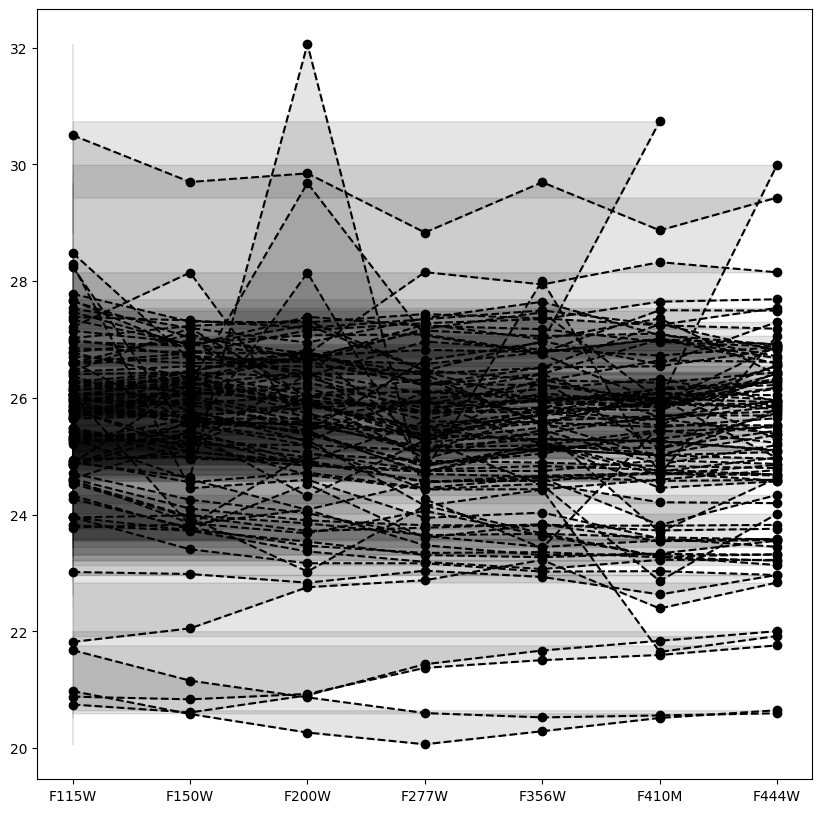

In [12]:
plt.figure(figsize=(10, 10))
for i in range(len(phot_list)):
    bandlabel = [key.replace('KronPhot_','').replace('_mag','') for key in key_phot]
    plt.plot(bandlabel, list(phot_list.as_array()[i]), marker='o', linestyle='--', color='k')
    plt.fill_betweenx(list(phot_list.as_array()[i]), bandlabel, color='k', alpha=0.1)
    plt.savefig(prep_dir + 'kronphot.png')

# Write to FITS file for GALFIT preparation

#### IMGLIST Extension

In [13]:
pregalfit_path = prep_dir + 'pregalfit.fits'

# Create an IMGLIST extension
hdr_img = fits.Header()
hdr_img['EXTNAME'] = 'IMGLIST'

tab_img = Table()
band_list = []
for img_path in img_path_list:
    print(img_path)
    hdr_pri = fits.getheader(img_path, extname='PRIMARY')
    band = hdr_pri['FILTER'].split(' ')[0]
    band_list.append(band)
tab_img.add_columns([band_list,img_path_list], names=['band', 'img_path'])
fits.writeto(pregalfit_path, tab_img.as_array(), header=hdr_img, overwrite=True)

./io/image/nircam1/hlsp_ceers_jwst_nircam_nircam1_f115w_dr0.5_i2d.fits
./io/image/nircam1/hlsp_ceers_jwst_nircam_nircam1_f150w_dr0.5_i2d.fits
./io/image/nircam1/hlsp_ceers_jwst_nircam_nircam1_f200w_dr0.5_i2d.fits
./io/image/nircam1/hlsp_ceers_jwst_nircam_nircam1_f277w_dr0.5_i2d.fits
./io/image/nircam1/hlsp_ceers_jwst_nircam_nircam1_f356w_dr0.5_i2d.fits
./io/image/nircam1/hlsp_ceers_jwst_nircam_nircam1_f410m_dr0.5_i2d.fits
./io/image/nircam1/hlsp_ceers_jwst_nircam_nircam1_f444w_dr0.5_i2d.fits


#### INIPARAM Extension

In [14]:
srccat = SourceCatalog(image_merged_conv, segm_matched)
srctab = srccat.to_table()
srctab.keep_columns(['label', 'xcentroid', 'ycentroid','orientation','eccentricity'])
tab_final = hstack([tab_phot,srctab])
tab_final

EGS-ID,KronPhot_F115W_mag,KronPhot_F150W_mag,KronPhot_F200W_mag,KronPhot_F277W_mag,KronPhot_F356W_mag,KronPhot_F410M_mag,KronPhot_F444W_mag,label,xcentroid,ycentroid,orientation,eccentricity
,,,,,,,,,,,deg,
int64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64
20625,25.408463749295972,25.197719055265747,25.196232651742182,25.10143257881045,25.117981951032576,25.019815957103162,24.956283638796947,536,793.5253114483905,219.4051305147803,34.75494487391395,0.8255118039033837
20569,24.874250999314405,26.238834851910386,29.680392456092218,27.070239209658883,26.745383724278923,25.925745907138218,26.334770185524384,563,2437.033597810577,216.7443585633355,-68.1715822369222,0.6463155681272001
38177,27.476537346429076,26.90026248528406,27.245820292740245,26.465648383795187,26.97180681430706,26.57469944731347,27.302966896305044,1550,3828.7868492442562,360.0878169201587,-11.97847151402135,0.4596474292719179
38262,27.15122942947573,26.93908310778188,27.0737005922733,27.087286673404112,26.775307164119525,27.50240222848074,27.494764273970503,2040,3621.7655353151904,478.8401392190717,-49.93716144938326,0.6300639889552743
21771,26.057544640058342,23.817796692536152,25.043519626756286,24.925430598040833,24.89214354415006,24.833845960092898,24.79854277289646,2854,3641.105968204329,665.3987868615525,47.08047238870054,0.5572955961296113
38740,26.606595114377985,26.76260452890451,27.157317292603675,27.280727465718073,27.349148225938418,27.64886828341968,27.69041767109777,5031,9642.625171201864,1122.7689979611603,-61.252048261568525,0.8027752236437623
23472,25.774726550588355,25.766858321954928,25.367420563486238,24.8672754689209,25.107053029257294,25.30437020861382,25.53204224972957,6368,1754.9276201526275,1368.3463279714363,4.234049841725214,0.7556245876022357
23708,26.134223640182864,26.34506770329039,25.88480388672873,25.478301241700102,25.69709602878418,25.935898293916104,25.811588587911864,6948,742.6260355620126,1468.1333149897118,-11.25156845668373,0.5653905803019336


In [15]:
# Create a INIPARAM extension
hdr_ini = fits.Header()
hdr_ini['EXTNAME'] = 'INIPARAM'
fits.append(pregalfit_path, tab_final.as_array(), header=hdr_ini, overwrite=True)

hdr_segm = fits.Header()
hdr_segm['EXTNAME'] = 'SEGMAP'
fits.append(pregalfit_path, segm.data, header=hdr_segm, overwrite=True)

In [16]:
with fits.open(pregalfit_path) as hdul:
    hdul.info()
    print(hdul[3].data)

Filename: ./io/prep/nircam1/pregalfit.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1  IMGLIST       1 BinTableHDU     13   7R x 2C   [5A, 70A]   
  2  INIPARAM      1 BinTableHDU     35   97R x 13C   [K, D, D, D, D, D, D, D, K, D, D, D, D]   
  3  SEGMAP        1 ImageHDU         8   (10600, 4800)   int64   
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
